In [15]:
#공통 코드

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
import seaborn as sns
import scipy as sp
from scipy import stats

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 노트북 실행 결과를 동일하게 유지하기 위해
# 모델 만드는 작업 여러번 하는 경우 시드가 변경이 되어 훈련용 데이터가 자주 변경되면 결국 모든 데이터를 가지고 모델을 생성하는 결과 
# -> Overfit이 될 가능성이 높아짐 
np.random.seed(42)


In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

C:\Users\USER\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [17]:
#피처와 타겟 가져오기
X, y = mnist["data"], mnist["target"]
print(X.shape)
#데이터는 784픽셍르 가진 흑백 이미지로 실제 크기는 28*28
#각 픽셀은 0~255까지의 값을 가짐
print(y.shape)

(70000, 784)
(70000,)


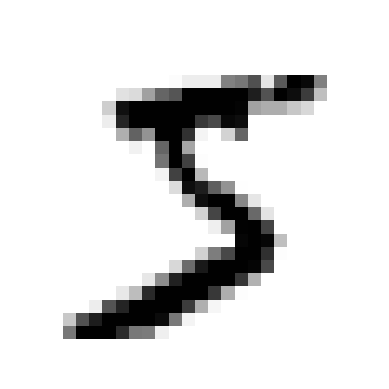

In [18]:
#하나의 이미지 출력
some_digit = X[0] 
some_digit_image = some_digit.reshape(28, 28) #2차원 이미지로 변환
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [19]:
#출력한 이미지의 레이블 확인
print(y[0])

5


In [20]:
#여러 개의 이미지 데이터를 행 단위로 출력하는 함수
#첫번째 매개변수는 이미지들, instance는 출력할 이미지 
#두번째 매개변수는 하나의 행에 출력할 이미지 수, images_per_row는 열의 수
#세번째 매개변수는 옵션으로 딕셔너리를 설정

#여러개의 옵션 설정해야하는 경우 나열하는 것은 가독성 떨어짐, 이런 경우 매개변수 하나로 묶어서 dict나 class 
#생략이 가능한 옵션을 많이 가지고 있으면 dict가 낫고 그러지 않으면 class를 사용

def plot_digits(instances, images_per_row=10, **options):
    #이미지 크기 설정
    size = 28
    #열의 개수 설정
    images_per_row = min(len(instances), images_per_row)
    #이미지 전체를 순회하면서 28 * 28로 설정
    images = [instance.reshape(size,size) for instance in instances]
    #행의 개수 구하기
    n_rows = (len(instances) - 1) // images_per_row + 1
    #이미지 들을 저장할 리스트
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    #0으로 가득채운 행렬을 만들어서 images 에 저장
    images.append(np.zeros((size, size * n_empty)))
    #행 단위로 순회하면서 이미지를 추가
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    #이미지 출력
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

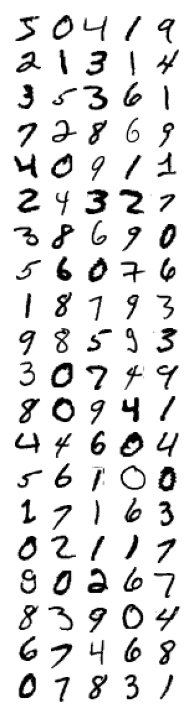

In [21]:
#여러 개의 이미지 출력 함수 확인
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
#save_fig("more_digits_plot")
plt.show()

In [22]:
#타겟의 자료형 확인 : str
#print(type(y[0]))
#일반적으로 데이터의 자료형은 정수를 권장
#타겟의 자료형 변경 
y = y.astype(np.uint8)
print(type(y[0]))

<class 'numpy.uint8'>


# 이진 분류를 위한 데이터 생성

In [23]:
#훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#이진 분류는 True와 False 로 분류 
#이진 분류의 경우 Target이 Bool
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

print(y_train_5[0])
print(y_test_5[0])

True
False


# SGDClassifier

In [24]:
#모델 생성 및 학습
from sklearn.linear_model import SGDClassifier

#훈련에 사용할 모델을 생성 - 하이퍼 파라미터를 설정
#max_iter는 작업 횟수 이고 tol은 정밀도 random_state는 seed 값
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

#훈련
sgd_clf.fit(X_train, y_train_5)

#예측 - feature는 2차원 배열 이상이어야 함. 하나여도 묶어서 주기
sgd_clf.predict([some_digit])

array([ True])

## k겹 교차 검증을 이용한 정확도 측정

In [25]:
from sklearn.model_selection import cross_val_score
#3번 교차 검증을 수행하는데 평가 지표는 정확도
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95, 0.96, 0.96])

In [26]:
#새로운 분류기를 가지고 훈련을 하고 교차 검정
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

#분류기 생성
never_5_clf = Never5Classifier()
#새로 만든 분류기의 정확도 확인
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.911, 0.909, 0.909])

## 분류의 평가지표

### 오차 행렬

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

#확률적 경사 하강법 모델을 가지고 훈련한 후 값을 예측 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#오차 행렬 출력
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [28]:
#다른 평가 지표 계산

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("정확도: %.2f" %accuracy_score(y_train_5, y_train_pred))
print("정밀도 : %.3f" % precision_score(y_train_5, y_train_pred))
print("재현율 : %.3f" % recall_score(y_train_5, y_train_pred))
print("F1 : %.3f" % f1_score(y_train_5, y_train_pred))

정확도: 0.96
정밀도 : 0.837
재현율 : 0.651
F1 : 0.733


In [29]:
#결정 임계값 - 기본값은 0

#자신의 점수를 출력
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

#전체 훈련 데이터의 점수를 출력
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[2164.22]
[  1200.931 -26883.792 -33072.035 ...  13272.127  -7258.472 -16877.508]


그림 저장: precision_recall_vs_threshold_plot


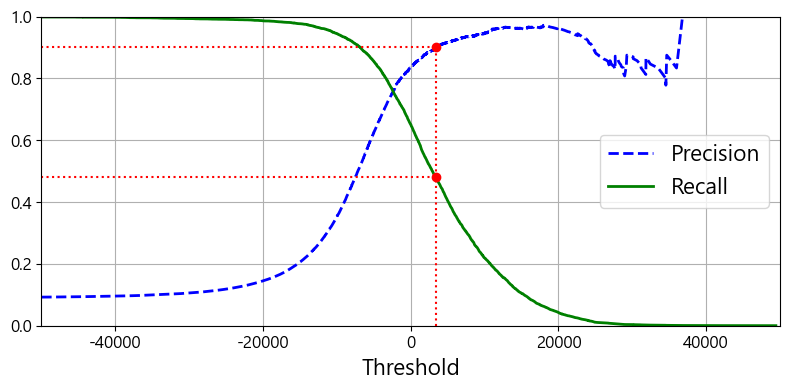

In [30]:
#정밀도와 재현율 트레이드 오프 
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


#정밀도 와 재현율 그리고 임계값을 그래프 그리는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])    
    
plt.figure(figsize=(8, 4))                                                                  

#정밀도와 재현율 출력
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)    
#plt.show()


#정밀도가 0.9 가 넘는 데이터 중의 인덱스 구하기 - 선을 그리기 위한 값을 찾기
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

In [31]:
#정밀도가 0.9가 되는 지점을 이용해서 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)
#정밀도
print(precision_score(y_train_5, y_train_pred_90))
#재현율
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


## ROC 곡선

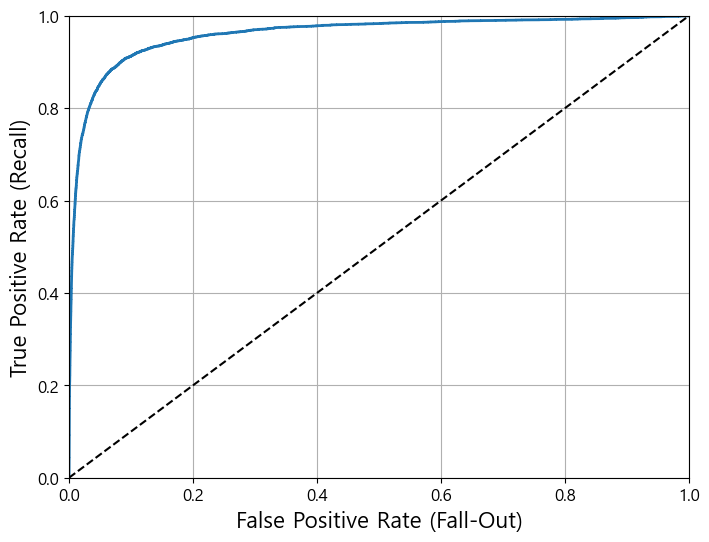

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
plt.show()

# fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
# plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
# plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
# plt.plot([fpr_90], [recall_90_precision], "ro")               
# save_fig("roc_curve_plot")                                    
# plt.show()

In [33]:
#ROC 곡선의 면적
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


# 다중 분류

## 이진 분류기를 이용한 다중 분류

In [34]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다

#첫번째 데이터 예측
print(svm_clf.predict([some_digit]))

#결정점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ 2.816  7.092  3.83   0.794  5.889  9.297  1.799  8.104 -0.228  4.838]]


# 판별 분석

## LDA(선형 판별 분석)

In [35]:
# borrower_score 와 payment_inc_ratio에 따른 outcome 선형 판별 분석(LDA)

#데이터 가져오기
loan3000 = pd.read_csv('./data/loan3000.csv')

#타겟을 범주형으로 전환
loan3000.outcome = loan3000.outcome.astype('category')

#숫자 컬럼들의 상관 계수를 전부 출력
print(loan3000.corr())

#독립 변수와 종속변수 설정
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

#데이터 읽어오기
X = loan3000[predictors] #독립변수 - feature
y = loan3000[outcome] #종속변수 - target 

print(X.head())
print(y.head())


                   Unnamed: 0       dti  borrower_score  payment_inc_ratio
Unnamed: 0           1.000000 -0.095606        0.249030          -0.102143
dti                 -0.095606  1.000000       -0.258860           0.232972
borrower_score       0.249030 -0.258860        1.000000          -0.109575
payment_inc_ratio   -0.102143  0.232972       -0.109575           1.000000
   borrower_score  payment_inc_ratio
0            0.40            5.11135
1            0.40            5.43165
2            0.70            9.23003
3            0.40            2.33482
4            0.45           12.10320
0    paid off
1     default
2    paid off
3    paid off
4     default
Name: outcome, dtype: category
Categories (2, object): ['default', 'paid off']


C:\Users\USER\AppData\Local\Temp\ipykernel_17392\3071581829.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(loan3000.corr())


In [36]:
#LDA 훈련
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

#최적의 borrower_score 와 payment_inc_ratio 값 구하기
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [37]:
#처음 5개의 데이터 판별 
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


## KNN 알고리즘을 이용

### loan200 읽어서 payment_inc_ratio와 dti 이용해서 outcome을 예측 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
#데이터 불러오기
loan200 = pd.read_csv('./data/loan200.csv')

predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

#테스트 데이터와 예측 변수 및 타겟 벡터 분리
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

print(X)
print(y)

     payment_inc_ratio    dti
1              5.46933  21.33
2              6.90294   8.97
3             11.14800   1.83
4              3.72120  10.81
5              1.89923  11.34
..                 ...    ...
196           11.66300  26.09
197            2.97641  16.41
198            1.96846  19.98
199            9.64200  20.17
200            7.03924  13.88

[200 rows x 2 columns]
1       default
2      paid off
3      paid off
4       default
5      paid off
         ...   
196     default
197     default
198     default
199    paid off
200    paid off
Name: outcome, Length: 200, dtype: object


In [39]:
#분류기 생성 - k (이웃)의 개수는 20
knn = KNeighborsClassifier(n_neighbors=20)
#데이터를 가지고 모델을 훈련 
knn.fit(X, y)
#예측
print(knn.predict(newloan))
#확률 확인
print(knn.predict_proba(newloan))

['paid off']
[[0.45 0.55]]


## 표준화

In [40]:
loan_data = pd.read_csv('data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)


   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


In [41]:
#정규화를 하지 않은 경우 가까운 5개의 이웃 구하기
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [42]:
#정규화를 한 경우 5개의 이웃 구하기
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])


       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


# Logistic Regression

## 붓꽃의 이진 분류 - virginica 인지 아닌지 여부 

In [43]:
#데이터 가져오고 속성 확인
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [44]:
#피처 생성
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(np.int_)  # Iris virginica이면 1 아니면 0
print(X)
print(y)

[[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.1]
 [0.1]
 [0.2]
 [0.4]
 [0.4]
 [0.3]
 [0.3]
 [0.3]
 [0.2]
 [0.4]
 [0.2]
 [0.5]
 [0.2]
 [0.2]
 [0.4]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.1]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.3]
 [0.3]
 [0.2]
 [0.6]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [1.4]
 [1.5]
 [1.5]
 [1.3]
 [1.5]
 [1.3]
 [1.6]
 [1. ]
 [1.3]
 [1.4]
 [1. ]
 [1.5]
 [1. ]
 [1.4]
 [1.3]
 [1.4]
 [1.5]
 [1. ]
 [1.5]
 [1.1]
 [1.8]
 [1.3]
 [1.5]
 [1.2]
 [1.3]
 [1.4]
 [1.4]
 [1.7]
 [1.5]
 [1. ]
 [1.1]
 [1. ]
 [1.2]
 [1.6]
 [1.5]
 [1.6]
 [1.5]
 [1.3]
 [1.3]
 [1.3]
 [1.2]
 [1.4]
 [1.2]
 [1. ]
 [1.3]
 [1.2]
 [1.3]
 [1.3]
 [1.1]
 [1.3]
 [2.5]
 [1.9]
 [2.1]
 [1.8]
 [2.2]
 [2.1]
 [1.7]
 [1.8]
 [1.8]
 [2.5]
 [2. ]
 [1.9]
 [2.1]
 [2. ]
 [2.4]
 [2.3]
 [1.8]
 [2.2]
 [2.3]
 [1.5]
 [2.3]
 [2. ]
 [2. ]
 [1.8]
 [2.1]
 [1.8]
 [1.8]
 [1.8]
 [2.1]
 [1.6]
 [1.9]
 [2. ]
 [2.2]
 [1.5]
 [1.4]
 [2.3]
 [2.4]
 [1.8]
 [1.8]
 [2.1]
 [2.4]
 [2.3]
 [1.9]

In [45]:
from sklearn.linear_model import LogisticRegression
#분류 모델 생성 
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
#모델 훈련
log_reg.fit(X, y)

#샘플 데이터 1000개를 생성해서 예측 
X_new = np.linspace(0,3,1000).reshape(-1,1)

#각 샘플의 확률을 계산
y_proba = log_reg.predict_proba(X_new)

#경계 점수
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
print(decision_boundary)

#예측
print(log_reg.predict([[1.7], [0.5]]))

[1.661]
[1 0]


## Logistic Regression을 이용한 다중 클래스 분류(카테고리 분류)

In [46]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int_)
print(X)
print(y)

[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [1.7 0.4]
 [1.4 0.3]
 [1.5 0.2]
 [1.4 0.2]
 [1.5 0.1]
 [1.5 0.2]
 [1.6 0.2]
 [1.4 0.1]
 [1.1 0.1]
 [1.2 0.2]
 [1.5 0.4]
 [1.3 0.4]
 [1.4 0.3]
 [1.7 0.3]
 [1.5 0.3]
 [1.7 0.2]
 [1.5 0.4]
 [1.  0.2]
 [1.7 0.5]
 [1.9 0.2]
 [1.6 0.2]
 [1.6 0.4]
 [1.5 0.2]
 [1.4 0.2]
 [1.6 0.2]
 [1.6 0.2]
 [1.5 0.4]
 [1.5 0.1]
 [1.4 0.2]
 [1.5 0.2]
 [1.2 0.2]
 [1.3 0.2]
 [1.4 0.1]
 [1.3 0.2]
 [1.5 0.2]
 [1.3 0.3]
 [1.3 0.3]
 [1.3 0.2]
 [1.6 0.6]
 [1.9 0.4]
 [1.4 0.3]
 [1.6 0.2]
 [1.4 0.2]
 [1.5 0.2]
 [1.4 0.2]
 [4.7 1.4]
 [4.5 1.5]
 [4.9 1.5]
 [4.  1.3]
 [4.6 1.5]
 [4.5 1.3]
 [4.7 1.6]
 [3.3 1. ]
 [4.6 1.3]
 [3.9 1.4]
 [3.5 1. ]
 [4.2 1.5]
 [4.  1. ]
 [4.7 1.4]
 [3.6 1.3]
 [4.4 1.4]
 [4.5 1.5]
 [4.1 1. ]
 [4.5 1.5]
 [3.9 1.1]
 [4.8 1.8]
 [4.  1.3]
 [4.9 1.5]
 [4.7 1.2]
 [4.3 1.3]
 [4.4 1.4]
 [4.8 1.4]
 [5.  1.7]
 [4.5 1.5]
 [3.5 1. ]
 [3.8 1.1]
 [3.7 1. ]
 [3.9 1.2]
 [5.1 1.6]
 [4.5 1.5]
 [4.5 1.6]
 [4.7 1.5]
 [4.4 1.3]
 [4.1 1.3]
 [4.  1.3]
 [4.4 1.2]

In [47]:
#분류기 생성 및 훈련
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs",C=10, random_state=42)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [ ]:
#샘플데이터 생성 
#linspace는 범위 안에 일정한 간격을 갖는 숫자 배열 생성 
#reshape 차원 변경 -1선택하면 나머지 전체
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )

In [51]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # 꽃잎 길이와 너비
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [52]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

### 타이타닉 데이터를 이용한 생존 여부 분류 - 결정 트리 모델 활용

In [53]:
### 기본 라이브러리 불러오기
import pandas as pd
import seaborn as sns

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [54]:
#결측치 처리 

#deck 열 결측치 너무 많아서 열을 제거, embark_town은 중복 제거
rdf = df.drop(['deck', 'embark_town'], axis=1)

#age 열 결측치가 아주 많진 않기 때문에 결측치 데이터를 제거 
rdf = rdf.dropna(subset=['age'], how='any', axis=0)  

#embarked 열은 결측치가 2개라서 최빈값으로 대체
most_freq = rdf['embarked'].value_counts(dropna=True).idxmax()   
rdf['embarked'].fillna(most_freq, inplace=True)

print(rdf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   survived    714 non-null    int64   
 1   pclass      714 non-null    int64   
 2   sex         714 non-null    object  
 3   age         714 non-null    float64 
 4   sibsp       714 non-null    int64   
 5   parch       714 non-null    int64   
 6   fare        714 non-null    float64 
 7   embarked    714 non-null    object  
 8   class       714 non-null    category
 9   who         714 non-null    object  
 10  adult_male  714 non-null    bool    
 11  alive       714 non-null    object  
 12  alone       714 non-null    bool    
dtypes: bool(2), category(1), float64(2), int64(4), object(4)
memory usage: 63.6+ KB
None


In [57]:
print(rdf.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male alive  alone  
0    man        True    no  False  
1  woman       False   yes  False  
2  woman       False   yes   True  
3  woman       False   yes  False  
4    man        True    no   True  


In [58]:

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf.drop(['sex', 'embarked'], axis=1, inplace=True)

# 속성(변수) 선택
X=ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y=ndf['survived']                      #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

# sklearn 라이브러리에서 Decision Tree 분류 모형 가져오기
from sklearn import tree
# 모형 객체 생성 (criterion='entropy' 적용 - 기본은 gini)
#최대 가지는 5단계로 설정
#단계가 높아지면 모형 학습에 사용하는 훈련 데이터에 대한 예측은 정확해지만 과적합 문제가 발생할 수 있음
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
# train data를 가지고 모형 학습
tree_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = tree_model.predict(X_test) 

print(y_hat[0:10])
print(y_test.values[0:10])
print('\n')

# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
tree_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(tree_matrix)
print('\n')

[0 0 1 0 0 1 1 0 0 0]
[0 0 1 0 0 1 1 1 0 0]


[[121   4]
 [ 35  55]]




In [60]:
tree_report = metrics.classification_report(y_test, y_hat)            
print(tree_report)

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       125
           1       0.93      0.61      0.74        90

    accuracy                           0.82       215
   macro avg       0.85      0.79      0.80       215
weighted avg       0.84      0.82      0.81       215



(-1.000, 9.000)

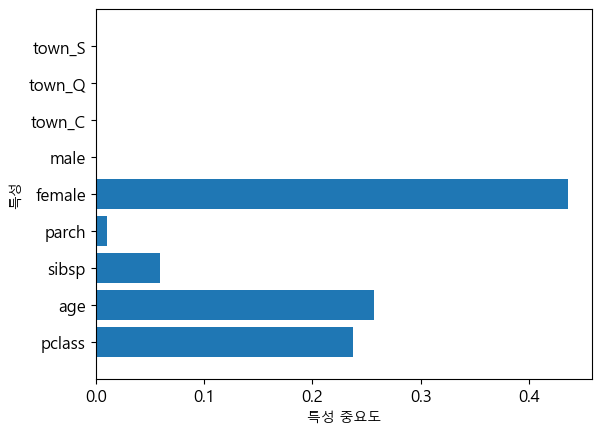

In [61]:
#특성 중요도 파악
n_features = X.data.shape[1]

plt.barh(np.arange(n_features), tree_model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['pclass', 'age', 'sibsp', 'parch', 'female', 'male', 
       'town_C', 'town_Q', 'town_S'])
plt.xlabel("특성 중요도")
plt.ylabel("특성")
plt.ylim(-1, n_features)